In [1]:
#Description: LSTM-model to predict 2 week time window of S&P 500

In [2]:
#Import libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import ta
plt.style.use("fivethirtyeight")

In [3]:
# Data collection
data = web.DataReader("^GSPC", data_source="yahoo", start="2016-1-1",end="2018-9-26")
#Plot data
print(data.Open.head(10))
print(data.Open.tail(15))
#Test time window data points= 11 

Date
2016-01-04    2038.199951
2016-01-05    2013.780029
2016-01-06    2011.709961
2016-01-07    1985.319946
2016-01-08    1945.969971
2016-01-11    1926.119995
2016-01-12    1927.829956
2016-01-13    1940.339966
2016-01-14    1891.680054
2016-01-15    1916.680054
Name: Open, dtype: float64
Date
2018-09-06    2888.639893
2018-09-07    2868.260010
2018-09-10    2881.389893
2018-09-11    2871.570068
2018-09-12    2888.290039
2018-09-13    2896.850098
2018-09-14    2906.379883
2018-09-17    2903.830078
2018-09-18    2890.739990
2018-09-19    2906.600098
2018-09-20    2919.729980
2018-09-21    2936.760010
2018-09-24    2921.830078
2018-09-25    2921.750000
2018-09-26    2916.979980
Name: Open, dtype: float64


In [4]:
# Create Open-price data frame
d_o=data.filter(["Open"])
#Convert dataframe in numpy array
d_np=d_o.values
n_test=11
#Get the number of rows to train the model on 
training_data_len=len(d_np)-n_test
testing_data_len=n_test
d_o

,Open
Date,
2016-01-04,2038.199951
2016-01-05,2013.780029
2016-01-06,2011.709961
2016-01-07,1985.319946
2016-01-08,1945.969971
...,...
2018-09-20,2919.729980
2018-09-21,2936.760010
2018-09-24,2921.830078


In [5]:
#Test whether lens are correct (test_len + train_len should be total len of data set)
print(d_np.shape)
print(training_data_len)
print(testing_data_len)

(689, 1)
678
11


In [6]:
# def expMovingAve_dec(df, window_short=50, window_long=200):
#     #50, 200
#     d_o[f'EMA{window_short}'] = ta.trend.ema_indicator(df.Open, window=window_short)
#     d_o[f'EMA{window_long}'] = ta.trend.ema_indicator(df.Open, window=window_long)
#     d_o['Signal_EMA'] = np.where(df[f'EMA{window_short}'] > df[f'EMA{window_long}'], 1.0, 0.0)
#     d_o['Decision EMA'] = df.Signal_EMA_EMA.diff()
#     return df

In [7]:
# def Goldencross_dec(df, window_short=20, window_long=50):
#     #50, 200
#     d_o[f'SMA{window_short}'] = ta.trend.sma_indicator(df.Open, window=window_short)
#     d_o[f'SMA{window_long}'] = ta.trend.sma_indicator(df.Open, window=window_long)
#     d_o['Signal_GC'] = np.where(df[f'SMA{window_short}'] > df[f'SMA{window_long}'], 1.0, 0.0)
#     d_o['Decision GC'] = df.Signal_GC.diff()
#     return df

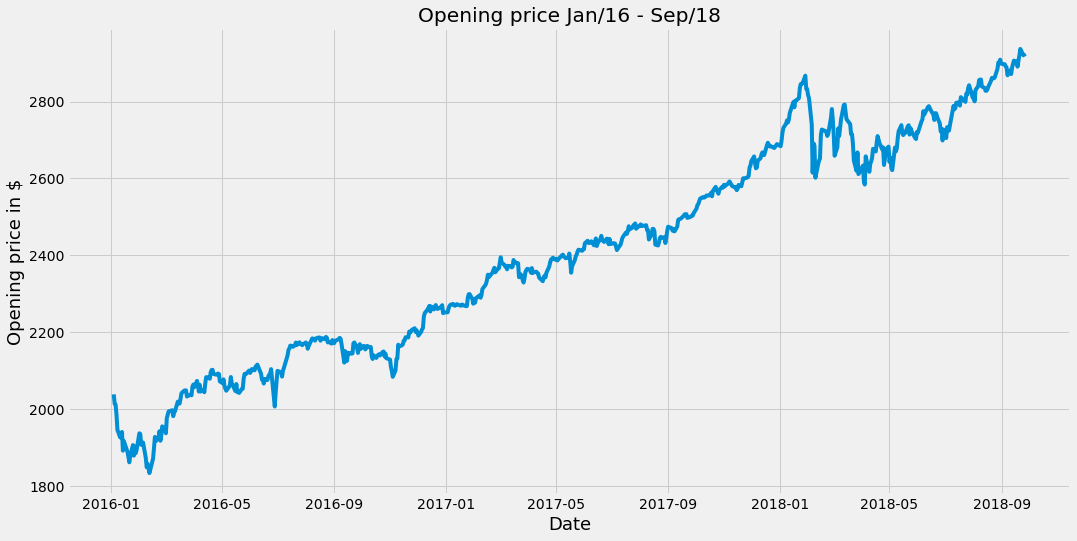

In [8]:
#Plot data (Opening price)
plt.figure(figsize=(16,8))
plt.title("Opening price Jan/16 - Sep/18")
plt.plot(d_o)
plt.xlabel("Date",fontsize=18)
plt.ylabel("Opening price in $",fontsize=18)
plt.show()

In [13]:
# Scale the data (Convert values between 0 & 1; 0 and 1 INCLUSIVE)
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(d_np)

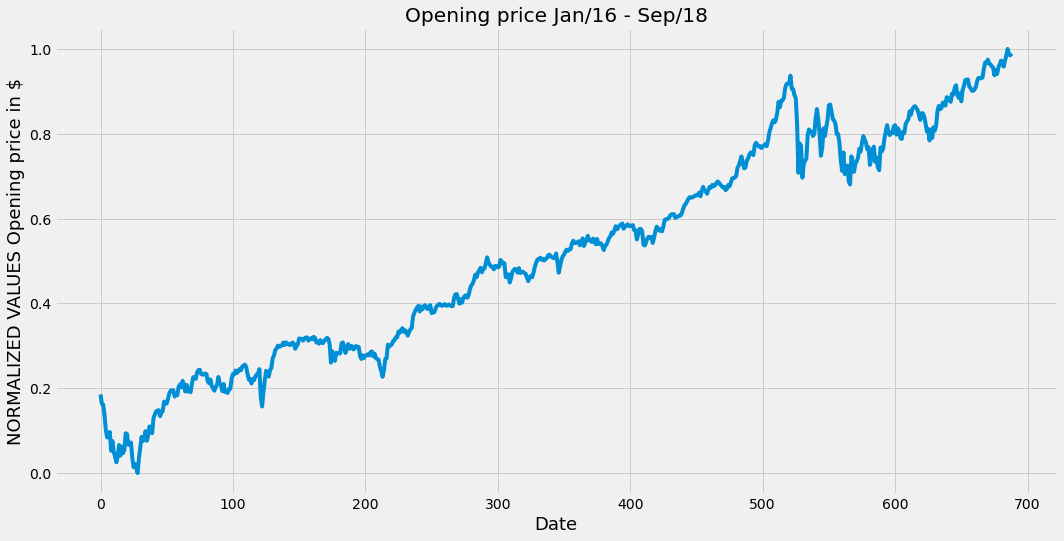

In [14]:
plt.figure(figsize=(16,8))
plt.title("Opening price Jan/16 - Sep/18")
plt.plot(scaled_data)
plt.xlabel("Date",fontsize=18)
plt.ylabel("NORMALIZED VALUES Opening price in $",fontsize=18)
plt.show()

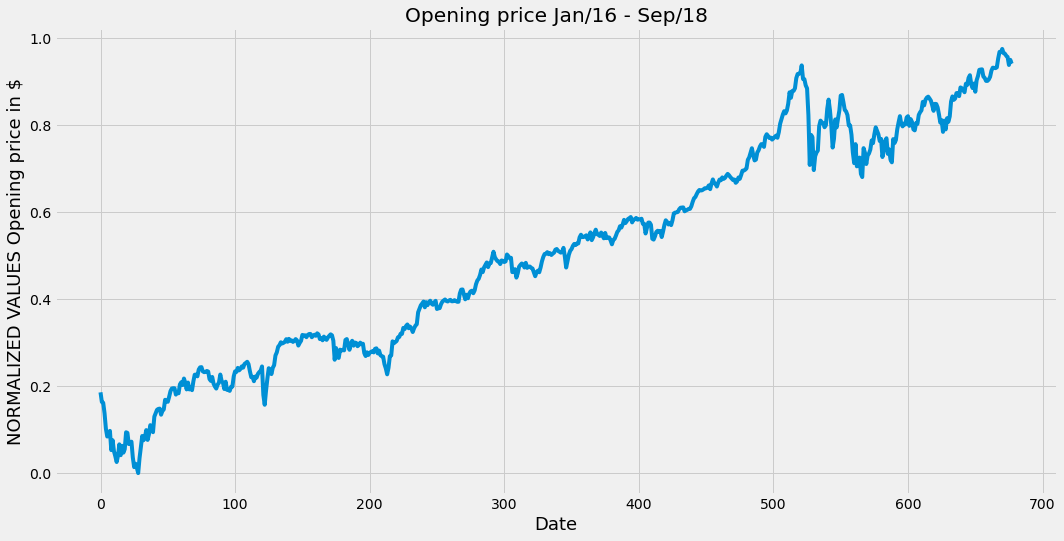

In [15]:
#Create training data set
#Create the scaled training data set
train_data=scaled_data[0:training_data_len, :]
#Split the data into x_train and y_train data sets
x_train = []
y_train = []
plt.figure(figsize=(16,8))
plt.title("Opening price Jan/16 - Sep/18")
plt.plot(train_data)
plt.xlabel("Date",fontsize=18)
plt.ylabel("NORMALIZED VALUES Opening price in $",fontsize=18)
plt.show()

In [16]:
#Create training set
len_batch=30

#Create batches + testing batch
for i in range(len_batch, len(train_data)):
    x_train.append(train_data[i-len_batch:i,0])
    y_train.append(train_data[i,0])
    #Test:
#     if i<=61:
#         print(x_train)
#         print(y_train)
#         print()

In [17]:
#Convert x_train and y_train to numpy arrays
x_train, y_train=np.array(x_train), np.array(y_train)

In [18]:
#Reshape the data for LSTM (#samples, #timestamps, #features)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(648, 30, 1)

In [19]:
#Build LSTM model

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))


In [20]:
#Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [21]:
#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

648/648 [==============================] - 8s 9ms/step - loss: 0.0037


In [22]:
#Create the testing data set
#Create a new array containing scaled values from index 
test_data=scaled_data[training_data_len-len_batch: , :]

#Create the data sets x_test and y_test
x_test = []
y_test = d_np[training_data_len:, :]
for i in range(len_batch, len(test_data)):
    x_test.append(test_data[i-len_batch:i, 0])

In [23]:
# Convert the data to numpy array (to use it in LSTM model)
x_test = np.array(x_test)

In [24]:
#Reshape the data (3-dim shape for LSTM)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [25]:
# Get the models predicted price values (for x_test dataset)
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

1/1 [==============================] - 1s 580ms/step


In [26]:
# Get the root mean squared error (RMSE)
# rmse = 0 means --> predictions = testing data values
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

23.721057872203307

C:\Users\kimer\AppData\Local\Temp/ipykernel_12596/4193678067.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["Predictions"] = predictions


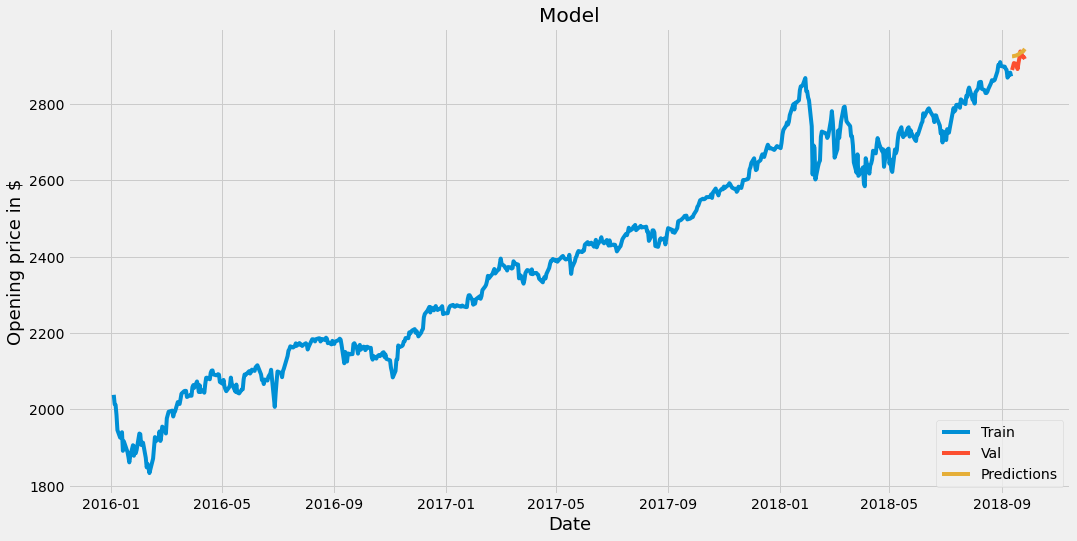

In [27]:
# Plot the data
train = d_o[:training_data_len]
valid = d_o[training_data_len:]
valid["Predictions"] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title("Model")
plt.xlabel("Date",fontsize=18)
plt.ylabel("Opening price in $", fontsize=18)
plt.plot(train["Open"]) #?
plt.plot(valid[["Open","Predictions"]])
plt.legend(["Train","Val", "Predictions"], loc="lower right")
plt.show()

In [ ]:
rmse_old= 58.64
rmse_new= 11.39